In [7]:
#@title Importar Librerías
import os
import tensorflow as tf
import tensorflow_hub as hub    #modelo pre-entrenado BiT
import time
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import keras
from tensorflow.keras import backend as K
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2
import random
import glob
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import gc
import imageio                  #manejo y visualización de archivos

In [8]:

if not os.path.isdir('up'):
  !git clone https://github.com/joaopauloschuler/PlantDoc-Object-Detection-Dataset.git up

Cloning into 'up'...
remote: Enumerating objects: 5190, done.
remote: Total 5190 (delta 0), reused 0 (delta 0), pack-reused 5190
Receiving objects: 100% (5190/5190), 941.89 MiB | 35.61 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.
Checking out files: 100% (5199/5199), done.


In [9]:
up_data_dir = os.getcwd()+"/up/TRAIN"
up_test_dir = os.getcwd()+"/up/TEST"
data_dir = "cropped_train/"
test_dir = "cropped_test/"
healthy_train_dir = "train/0/"
unhealthy_train_dir = "train/1/"
healthy_test_dir = "test/0/"
unhealthy_test_dir = "test/1/"


In [10]:
def CropImages(orig_data_dir, dest_data_dir, csv_file, include_original=False, verbose=True, prefix='img_'):
  # Load the CSV file.
  with open (csv_file, "r") as myfile:
    csv_lines=myfile.readlines()

  # Transform the CSV file into an array  
  line_count = 0
  a_lines = []
  for str_line in csv_lines:
    if line_count > 0: 
      a_line = str_line.replace('\n', '').split(',')
      a_lines.append(a_line)
    line_count = line_count + 1
  
  # create destination folder
  if not os.path.isdir(dest_data_dir):
    os.mkdir(dest_data_dir)

  # Save cropped images
  line_count = 0
  failed_count = 0
  original_count = 0
  last_image_file = ''
  for a_line in a_lines:
    dest_folder_name = dest_data_dir+'/'+a_line[3].replace(" ","_")
    dest_file_name = dest_folder_name+'/'+prefix+str(line_count)+'.jpg'
    orig_file_name = orig_data_dir+'/'+ a_line[0]
    print(line_count,':', a_line, dest_file_name)
    if last_image_file != orig_file_name:
      if os.path.isfile(orig_file_name):
        img = cv2.imread(orig_file_name)
        #cv2_imshow(img)
        last_image_file = orig_file_name
        can_load = True
        original_count = original_count + 1
        if verbose: print("Original imgage shape",img.shape)
        if (include_original):
          if not os.path.isdir(dest_folder_name):
            os.mkdir(dest_folder_name)
          cv2.imwrite(dest_folder_name+'/ori_'+prefix+str(original_count)+'.jpg',img)  
      else:
        if verbose: print('File does not exist:', orig_file_name)
        can_load = False
        #break
    if (can_load):
      y1 = int(a_line[4])
      x1 = int(a_line[5])
      y2 = int(a_line[6])
      x2 = int(a_line[7])

      x_min = np.min([x1, x2])
      x_max = np.max([x1, x2])
      y_min = np.min([y1, y2])
      y_max = np.max([y1, y2])

      crop_img = img[x_min:x_max, y_min:y_max]
      if verbose: print("Cropped imgage shape",crop_img.shape,':', x_min, x_max, y_min, y_max,' deltas:',x_max - x_min, y_max - y_min)
      if not os.path.isdir(dest_folder_name):
        os.mkdir(dest_folder_name)
      if ( (crop_img.shape[0]==0) or (crop_img.shape[1]==0)):
        failed_count = failed_count + 1
        if verbose: print("Failed cropping.");
      else:
        cv2.imwrite(dest_file_name,crop_img)
    else:
      failed_count = failed_count + 1
    line_count = line_count + 1
  print("Processed files:", line_count, "Failed count: ", failed_count, "Original count:", original_count)

In [11]:
if not os.path.isdir(data_dir):
  CropImages(orig_data_dir=up_data_dir, dest_data_dir=data_dir, csv_file='up/train_labels.csv', include_original=False, prefix='train_')

Se truncaron las últimas líneas 5000 del resultado de transmisión.
6274 : ['3_21_14-Caption-Black-Rot-leaf-infection.-265x265.jpg', '265', '265', 'grape leaf black rot', '1', '9', '136', '239'] cropped_train//grape_leaf_black_rot/train_6274.jpg
Original imgage shape (265, 265, 3)
Cropped imgage shape (230, 135, 3) : 9 239 1 136  deltas: 230 135
6275 : ['603-116-0.jpg', '502', '670', 'Tomato mold leaf', '1', '158', '358', '670'] cropped_train//Tomato_mold_leaf/train_6275.jpg
Original imgage shape (670, 502, 3)
Cropped imgage shape (512, 357, 3) : 158 670 1 358  deltas: 512 357
6276 : ['IMG_4280.JPG.jpg', '1600', '1200', 'Cherry leaf', '117', '194', '655', '589'] cropped_train//Cherry_leaf/train_6276.jpg
Original imgage shape (1200, 1600, 3)
Cropped imgage shape (395, 538, 3) : 194 589 117 655  deltas: 395 538
6277 : ['IMG_4280.JPG.jpg', '1600', '1200', 'Cherry leaf', '803', '264', '1018', '658'] cropped_train//Cherry_leaf/train_6277.jpg
Cropped imgage shape (394, 215, 3) : 264 658 803 1

In [12]:
if not os.path.isdir(test_dir):
  CropImages(orig_data_dir=up_test_dir, dest_data_dir=test_dir, csv_file='up/test_labels.csv', include_original=False, prefix='test_')

0 : ['Black%20rot%20on%20foliage.jpg', '1060', '795', 'grape leaf black rot', '1', '58', '859', '732'] cropped_test//grape_leaf_black_rot/test_0.jpg
Original imgage shape (795, 1060, 3)
Cropped imgage shape (674, 858, 3) : 58 732 1 859  deltas: 674 858
1 : ['pepper_leaf.jpg', '300', '400', 'Bell_pepper leaf', '40', '58', '251', '392'] cropped_test//Bell_pepper_leaf/test_1.jpg
Original imgage shape (400, 300, 3)
Cropped imgage shape (334, 211, 3) : 58 392 40 251  deltas: 334 211
2 : ['depositphotos_1323264-Raspberry-leaf-on-white.jpg', '1024', '772', 'Raspberry leaf', '98', '75', '964', '710'] cropped_test//Raspberry_leaf/test_2.jpg
Original imgage shape (772, 1024, 3)
Cropped imgage shape (635, 866, 3) : 75 710 98 964  deltas: 635 866
3 : ['dscn6689.jpg', '1024', '768', 'Tomato mold leaf', '140', '102', '887', '712'] cropped_test//Tomato_mold_leaf/test_3.jpg
Original imgage shape (768, 1024, 3)
Cropped imgage shape (610, 747, 3) : 102 712 140 887  deltas: 610 747
4 : ['IMG_1246.jpg', '

In [13]:
if not os.path.isdir("train"):
  !mkdir train

In [14]:
if not os.path.isdir("test"):
  !mkdir test

In [15]:
#@title Asignar la etiqueta de hoja sana a las siguientes clases de entrenamiento
if not os.path.isdir(healthy_train_dir):
  !mkdir train/0
  ! cp -r cropped_train/Apple_leaf/* train/0/
  ! cp -r cropped_train/Bell_pepper_leaf/* train/0/
  ! cp -r cropped_train/Blueberry_leaf/* train/0/
  ! cp -r cropped_train/Cherry_leaf/* train/0/
  ! cp -r cropped_train/grape_leaf/* train/0/
  ! cp -r cropped_train/Peach_leaf/* train/0/
  ! cp -r cropped_train/Potato_leaf/* train/0/
  ! cp -r cropped_train/Raspberry_leaf/* train/0/
  ! cp -r cropped_train/Soyabean_leaf/* train/0/
  ! cp -r cropped_train/Strawberry_leaf/* train/0/
  ! cp -r cropped_train/Tomato_leaf/* train/0/


In [16]:
#@title Asignar la etiqueta de hoja enferma a las siguientes clases de entrenamiento
if not os.path.isdir(unhealthy_train_dir):
  !mkdir train/1
  ! cp -r cropped_train/Apple_rust_leaf/* train/1/
  ! cp -r cropped_train/Apple_Scab_Leaf/* train/1/
  ! cp -r cropped_train/Bell_pepper_leaf_spot/* train/1/
  ! cp -r cropped_train/Corn_Gray_leaf_spot/* train/1/
  ! cp -r cropped_train/Corn_leaf_blight/* train/1/
  ! cp -r cropped_train/Corn_rust_leaf/* train/1/
  ! cp -r cropped_train/grape_leaf_black_rot/* train/1/
  ! cp -r cropped_train/Potato_leaf_early_blight/* train/1/
  ! cp -r cropped_train/Potato_leaf_late_blight/* train/1/
  ! cp -r cropped_train/Squash_Powdery_mildew_leaf/* train/1/
  ! cp -r cropped_train/Tomato_Early_blight_leaf/* train/1/
  ! cp -r cropped_train/Tomato_leaf_bacterial_spot/* train/1/
  ! cp -r cropped_train/Tomato_leaf_late_blight/* train/1/
  ! cp -r cropped_train/Tomato_leaf_mosaic_virus/* train/1/
  ! cp -r cropped_train/Tomato_leaf_yellow_virus/* train/1/
  ! cp -r cropped_train/Tomato_mold_leaf/* train/1/
  ! cp -r cropped_train/Tomato_Septoria_leaf_spot/* train/1/
  ! cp -r cropped_train/Tomato_two_spotted_spider_mites_leaf/* train/1/


In [17]:
#@title Asignar la etiqueta de hoja sana a las siguientes clases de test
if not os.path.isdir(healthy_test_dir):
  !mkdir test/0
  ! cp -r cropped_test/Apple_leaf/* test/0/
  ! cp -r cropped_test/Bell_pepper_leaf/* test/0/
  ! cp -r cropped_test/Blueberry_leaf/* test/0/
  ! cp -r cropped_test/Cherry_leaf/* test/0/
  ! cp -r cropped_test/grape_leaf/* test/0/
  ! cp -r cropped_test/Peach_leaf/* test/0/
  ! cp -r cropped_test/Raspberry_leaf/* test/0/
  ! cp -r cropped_test/Soyabean_leaf/* test/0/
  ! cp -r cropped_test/Strawberry_leaf/* test/0/
  ! cp -r cropped_test/Tomato_leaf/* test/0/

In [18]:
#@title Asignar la etiqueta de hoja enferma a las siguientes clases de test
if not os.path.isdir(unhealthy_test_dir):
  !mkdir test/1
  ! cp -r cropped_test/Apple_rust_leaf/* test/1/
  ! cp -r cropped_test/Apple_Scab_Leaf/* test/1/
  ! cp -r cropped_test/Bell_pepper_leaf_spot/* test/1/
  ! cp -r cropped_test/Corn_Gray_leaf_spot/* test/1/
  ! cp -r cropped_test/Corn_leaf_blight/* test/1/
  ! cp -r cropped_test/Corn_rust_leaf/* test/1/
  ! cp -r cropped_test/grape_leaf_black_rot/* test/1/
  ! cp -r cropped_test/Potato_leaf_early_blight/* test/1/
  ! cp -r cropped_test/Potato_leaf_late_blight/* test/1/
  ! cp -r cropped_test/Squash_Powdery_mildew_leaf/* test/1/
  ! cp -r cropped_test/Tomato_Early_blight_leaf/* test/1/
  ! cp -r cropped_test/Tomato_leaf_bacterial_spot/* test/1/
  ! cp -r cropped_test/Tomato_leaf_late_blight/* test/1/
  ! cp -r cropped_test/Tomato_leaf_mosaic_virus/* test/1/
  ! cp -r cropped_test/Tomato_leaf_yellow_virus/* test/1/
  ! cp -r cropped_test/Tomato_mold_leaf/* test/1/
  ! cp -r cropped_test/Tomato_Septoria_leaf_spot/* test/1/

In [19]:
train_path='train/*/*'  #ruta al conjuno de entrenamiento
valid_path='test/*/*'  #ruta al conjunto de pruebas

b'train/1/train_2233.jpg'
Tamaño de imagen: (92, 66, 3)
b'train/0/train_1677.jpg'
Tamaño de imagen: (348, 294, 3)
b'train/0/train_7373.jpg'
Tamaño de imagen: (450, 628, 3)
b'train/0/train_1520.jpg'
Tamaño de imagen: (180, 187, 3)
b'train/1/train_4479.jpg'
Tamaño de imagen: (315, 170, 3)


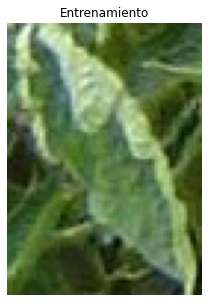

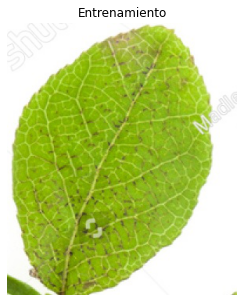

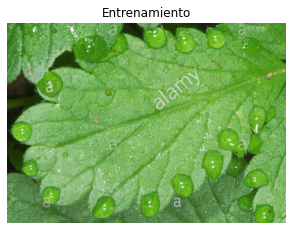

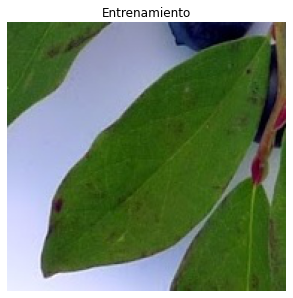

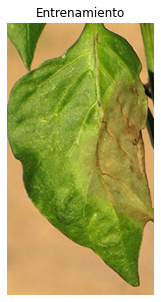

In [20]:
#Se muestran algunas imagenes aleatorias del conjunto de entrenamiento y su tamaño en pixeles
encoding = 'utf-8'
leaf_ds_train=tf.data.Dataset.list_files(train_path,shuffle=True)
for file in leaf_ds_train.take(5):
    print(file.numpy())    
    pic=imageio.imread(str(file.numpy(), encoding))
    print("Tamaño de imagen:",pic.shape)
    f, ax1 = plt.subplots(1,figsize=(5,5))
    ax1.axis('off')
    ax1.imshow(pic)
    ax1.set_title('Entrenamiento')

b'test/0/test_420.jpg'
Tamaño de imagen: (416, 299, 3)
b'test/0/test_214.jpg'
Tamaño de imagen: (1184, 1494, 3)
b'test/0/test_203.jpg'
Tamaño de imagen: (2107, 1772, 3)
b'test/1/test_392.jpg'
Tamaño de imagen: (195, 104, 3)
b'test/1/test_438.jpg'
Tamaño de imagen: (254, 288, 3)


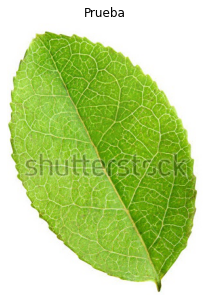

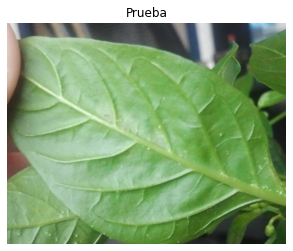

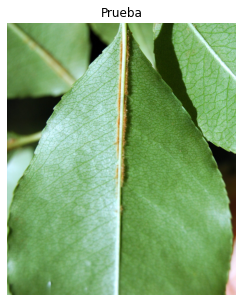

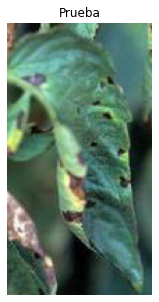

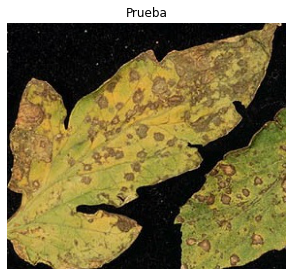

In [21]:
#Se muestran algunas imagenes aleatorias del conjunto de pruebas y su tamaño en pixeles
leaf_ds_test=tf.data.Dataset.list_files(valid_path,shuffle=True)
for file in leaf_ds_test.take(5):
    print(file.numpy())
    pic=imageio.imread(str(file.numpy(), encoding))
    print("Tamaño de imagen:",pic.shape)
    f, ax1 = plt.subplots(1,figsize=(5,5))
    ax1.axis('off')
    ax1.imshow(pic)
    ax1.set_title('Prueba')

In [22]:
count_leaf_train=len(leaf_ds_train)
count_leaf_test=len(leaf_ds_test)
print ("Imagenes de entrenamiento:",count_leaf_train)
print ("Imagenes de prueba:",count_leaf_test)
#Se obtiene el tamaño del conjunto de datos

Imagenes de entrenamiento: 8432
Imagenes de prueba: 451


In [23]:
#@title Configurar los hyperparametros de acuerdo al dataset

#@markdown Si las imagenes son menores a 96x96px se escalarán a 160x160px y se recortarán a 128x128px, si son superiores se esclarán a 512x512px y se recortarán a 480x480px. La cantidad de pasos para la sintonización fina será mayor si el conjunto de datos es más grande.

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [24]:
#Función que ayuda a extraer las etiquetas de los folderes en los que están las imagenes  de entrenamiento y validación (0-->Sanas 1-->Enfermas)
def get_label(file_path):
    import os
    return tf.strings.split(file_path,os.path.sep)[-2]

In [25]:
#Función que lee, preprocesa y normaliza las imagenes para juntarlo con su etiqueta del conjunto de datos de entrenamiento
def obt_image_train(file_path):
    label=get_label(file_path)
    img=tf.io.read_file(file_path)
    img=tf.image.decode_jpeg(img)
    img=tf.image.random_flip_left_right(img)
    img=tf.image.resize(img, [RESIZE_TO, RESIZE_TO])
    img=tf.image.random_crop(img, [CROP_TO, CROP_TO, 3])
    img=tf.cast(img, tf.float32) / 255.0
    label=tf.strings.to_number(label)
    return img,label

In [26]:
#Función que lee las imagenes, las normaliza y las junta con su etiqueta del conjunto de datos de prueba
def obt_image_test(file_path):
    label=get_label(file_path)
    img=tf.io.read_file(file_path)
    img=tf.image.decode_jpeg(img)
    img=tf.image.resize(img, [RESIZE_TO, RESIZE_TO])
    img=tf.cast(img, tf.float32) / 255.0
    label=tf.strings.to_number(label)
    return img,label

In [27]:
#Prueba para mostrar 5 ejemplos de valores de una imagen y etiqueta
for img,label in leaf_ds_test.map(obt_image_test).take(5):
   print("image:",img.numpy()[0][0])
   print("label:",label.numpy())

image: [0.55258447 0.68496454 0.23249999]
label: 0.0
image: [0.30842525 0.33342525 0.31724876]
label: 0.0
image: [0.04313726 0.08627451 0.02352941]
label: 1.0
image: [1. 1. 1.]
label: 1.0
image: [0.73378676 0.78058827 0.6009681 ]
label: 0.0


In [28]:
#Se obtiene el numero de ejemplos de hojas sanas y enfermas
path, dirs, files = next(os.walk("train/0"))
sanas = len(files)
path, dirs, files = next(os.walk("train/1"))
enfermas = len(files)

print("Hojas sanas:",sanas)
print("Hojas enfermas:",enfermas)

Hojas sanas: 4033
Hojas enfermas: 4399


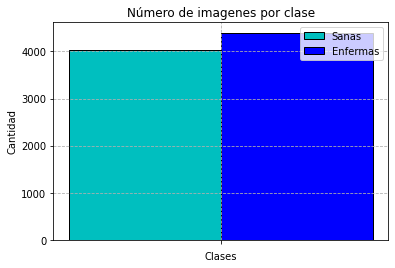

In [29]:
#Se grafican las clases existentes para verificar su proporción
r = np.arange(1)
width = 0.1
plt.bar(r, sanas, color = 'c',width = width, edgecolor = 'black',label='Sanas')
plt.bar(r + width, enfermas, color = 'b',width = width, edgecolor = 'black',label='Enfermas')
  
plt.xlabel("Clases")
plt.ylabel("Cantidad")
plt.title("Número de imagenes por clase")
  
plt.grid(linestyle='--')
plt.xticks(r + width/2,[])
plt.legend()
  
plt.show()

# Se nota que las clases están desbalanceadas por lo que será necesario usar métricas adicionales como Precision, Recall y f1-score

In [30]:
#Valores para definir los hyperparametros de entrenamiento dependiedo del dataset
NUM_CLASSES = 2
num_classes=NUM_CLASSES
DATASET_NUM_TRAIN_EXAMPLES = 8432

In [31]:
# Cargar el modelo entrenado en imagenet
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)  #Se carga el modulo de keras desde el repositorio de tensorflow

In [32]:
BATCH_SIZE = 128 #512    Se usa 128 para que la memoria en colab no falle
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE    #Factor que define 
STEPS_PER_EPOCH = 10

#Crear data pipelines para el entrenamiento y testing:
pipeline_train = (leaf_ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  
                  .map(obt_image_train,num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

pipeline_test = (leaf_ds_test
                  .map(obt_image_train, num_parallel_calls=1)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [33]:
# Agregar la capa de salida al modelo pre-entrenado y generar modelo

class MyBiTModel(tf.keras.Model):
 
  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros') #Capa de salida con el numero de clases deseado
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [34]:
# Se define el learning rate inicial dependiente del batch size
lr = 0.003 * BATCH_SIZE / 512 

# Desenso del learning rate por factor de 10 dentro de los SCHEDULE_BOUNDARIES definidos en BiT-HyperRule. 
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)#Se define un optimizador de gradiente descendiente con momentum y learning rate recomendados 

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)#Se define la función de perdida que codificará las salidas como categoricas

In [35]:
#Ya que el calculo del F1-score ha sido quitado de keras, la comunidad ofrece una implementación alternativa
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))#Calculo del recall
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))#Calculo de la presición
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)#Calculo del F1-score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy',f1_m,precision_m, recall_m]) #Se compila el modelo con los hyperparametros definidos

In [37]:
'''checkpoint = ModelCheckpoint("Epoca:{epoch:02d}-loss:{val_loss:.3f}-val_acc:{val_accuracy:.3f}-weights", save_weights_only=True, monitor="val_acc", mode="max")

early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, mode="max")

callbacks = [checkpoint, early_stopping]''' #Se guarada los resultados de cada epoca

'checkpoint = ModelCheckpoint("Epoca:{epoch:02d}-loss:{val_loss:.3f}-val_acc:{val_accuracy:.3f}-weights", save_weights_only=True, monitor="val_acc", mode="max")\n\nearly_stopping = EarlyStopping(monitor="val_accuracy", patience=10, mode="max")\n\ncallbacks = [checkpoint, early_stopping]'

In [38]:
# Sintonización fina con los pipelines definidos
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= 50, #int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  #Se tomaron menos epocas para acortar el tiempo de entrenamiento 
    validation_data=pipeline_test
    #callbacks=callbacks
)

Epoch 1/50
10/10 [==============================] - 156s 14s/step - loss: 0.3753 - accuracy: 0.7937 - f1_m: 0.5303 - precision_m: 0.4424 - recall_m: 0.6747 - val_loss: 0.1787 - val_accuracy: 0.9224 - val_f1_m: 0.7226 - val_precision_m: 0.5969 - val_recall_m: 0.9155
Epoch 2/50
10/10 [==============================] - 135s 14s/step - loss: 0.1746 - accuracy: 0.9242 - f1_m: 0.6764 - precision_m: 0.5313 - recall_m: 0.9336 - val_loss: 0.1903 - val_accuracy: 0.9401 - val_f1_m: 0.7293 - val_precision_m: 0.5903 - val_recall_m: 0.9564
Epoch 3/50
10/10 [==============================] - 137s 14s/step - loss: 0.2305 - accuracy: 0.9242 - f1_m: 0.6696 - precision_m: 0.5175 - recall_m: 0.9535 - val_loss: 0.1914 - val_accuracy: 0.9335 - val_f1_m: 0.7296 - val_precision_m: 0.5985 - val_recall_m: 0.9386
Epoch 4/50
10/10 [==============================] - 142s 15s/step - loss: 0.2009 - accuracy: 0.9328 - f1_m: 0.6836 - precision_m: 0.5344 - recall_m: 0.9521 - val_loss: 0.1650 - val_accuracy: 0.9424 - va

In [39]:
#Funcion para graficar la evolución de Accuracy, Presicion, Recall y el f1-score durante el entrenamiento
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
  val_f1_m = log.history['val_f1_m']
  val_precision_m = log.history['val_precision_m']
  val_recall_m = log.history['val_recall_m']

  fig, axes = plt.subplots(5, figsize=(25,30))
  ax1, ax2, ax3, ax4, ax5 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')

  ax2.plot(log.history['accuracy'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')

  ax3.plot(log.history['f1_m'], label='train')
  ax3.plot(val_f1_m, label='test')
  ax3.set_xlabel('epoch'); ax3.set_ylabel('f1 score')

  ax4.plot(log.history['precision_m'], label='train')
  ax4.plot(val_precision_m, label='test')
  ax4.set_xlabel('epoch'); ax4.set_ylabel('precision')  

  ax5.plot(log.history['recall_m'], label='train')
  ax5.plot(val_recall_m, label='test')
  ax5.set_xlabel('epoch'); ax5.set_ylabel('recall')  

  for ax in axes: ax.legend()

In [ ]:
#history.history

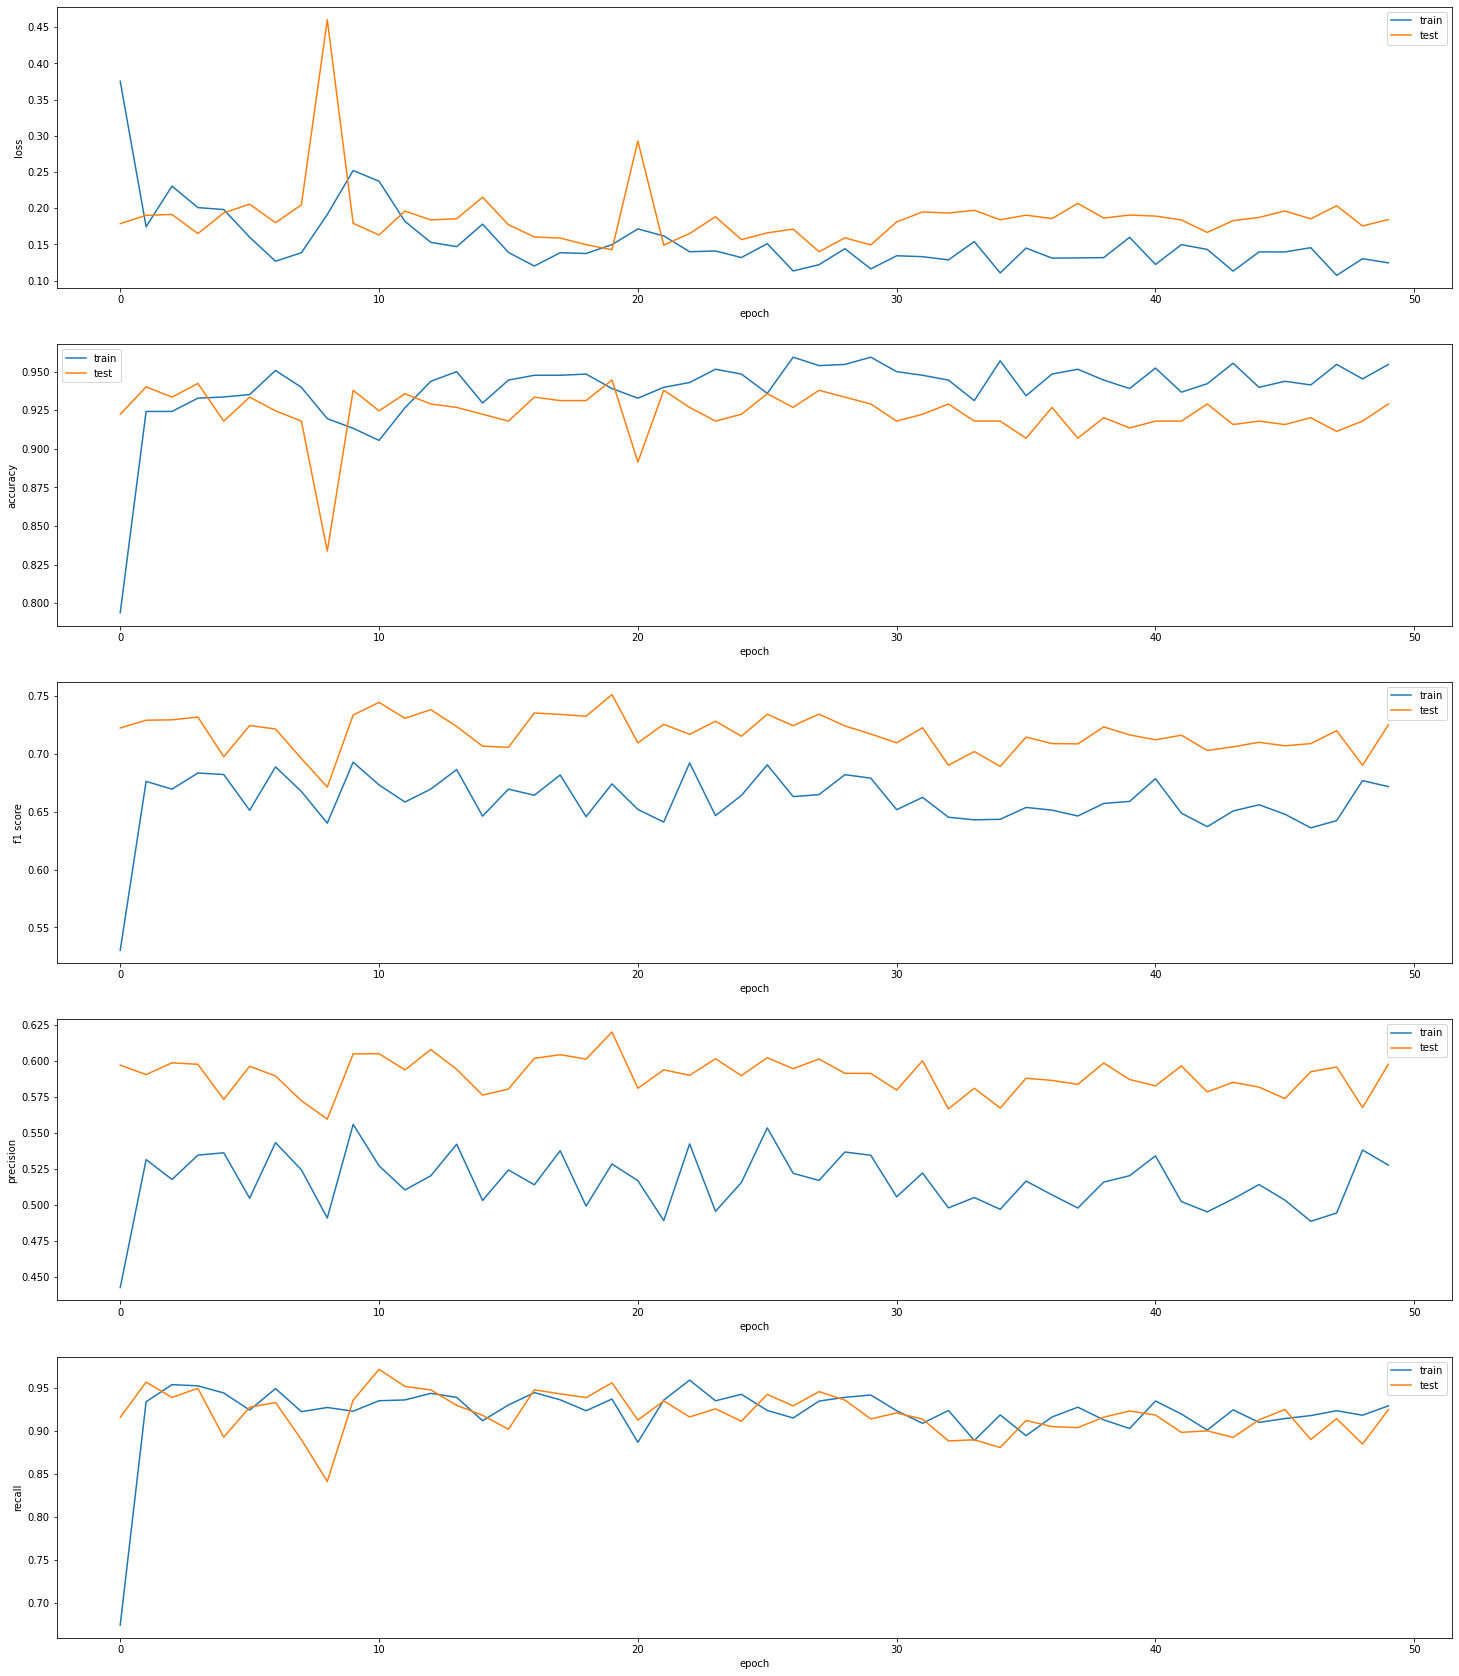

In [40]:
show_results(history)

In [41]:
model.summary() #Resumen del modelo entrenado

Model: "my_bi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  4098      
                                                                 
 keras_layer (KerasLayer)    multiple                  23500352  
                                                                 
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


In [42]:
keep = 'binario'  #Ruta para guardar el modelo

In [43]:
tf.saved_model.save(model, keep)  #Se guarda el modelo como un keras layer

INFO:tensorflow:Assets written to: binario/assets


INFO:tensorflow:Assets written to: binario/assets


In [44]:
# Load saved model
saved_model = hub.KerasLayer(keep, trainable=True)  #Se carga el modelo guardado
#saved_model = tf.saved_model.load(keep)

In [45]:
#Se obtiene los datos de prueba 
ds_val=leaf_ds_test.map(obt_image_test)
ds_val=ds_val.batch(2)
ds_val

<BatchDataset shapes: ((None, 160, 160, None), (None,)), types: (tf.float32, tf.float32)>

In [46]:
#Se evalua el modelo con los datos de prueba
loss, accuracy, f1_score, precision, recall = model.evaluate(ds_val, verbose=1)

226/226 [==============================] - 91s 391ms/step - loss: 0.1561 - accuracy: 0.9357 - f1_m: 0.6268 - precision_m: 0.5730 - recall_m: 0.7588


Aqui se observa que el Accuracy es bastante alto a pesar de las bajas epocas que se entrenó el modelo. Sin embargo, la Presicion es baja y el Recall es más que aceptable. Eso quiere decir que el modelo da demasiadas predicciones de plantas enfermas, pero estas predicciones cubren gran parte de las verdaderas plantas enfermas.

In [47]:
saved_model

Text(0.5, 1.0, 'Imagen a Probar')

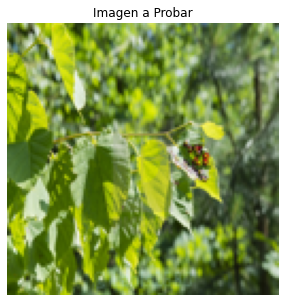

In [48]:
#En está parte se puede cargar una imagen de internet y el modelo analizará si la hoja está enferma o sana
import imageio

path_predict='https://res.cloudinary.com/fleetnation/image/private/c_fit,w_1120/g_south,l_text:style_gothic2:%C2%A9%20Lapis2380,o_20,y_10/g_center,l_watermark4,o_25,y_50/v1469430352/t7jjhchf5elkepdoulkz.jpg'#'/content/drive/MyDrive/dataset/test/test/PotatoHealthy1.JPG'

img=imageio.imread(path_predict)
img=Image.fromarray(img).resize((128,128))
img = np.asarray(img, dtype=float)

# Dividir entre 255 para que los valores estén en el rango 0 - 1
img = img / 255
f, ax1 = plt.subplots(1,figsize=(5,5))
ax1.axis('off')
ax1.imshow(img)
ax1.set_title('Imagen a Probar')

In [49]:
#img = img.reshape(-1,256,256,3)
img = img.reshape(-1,128,128,3)  #Se redimensiona la imagen para que pueda ser procesada por el modelo
img.shape

(1, 128, 128, 3)

In [50]:
salida = saved_model(img)        #Dependiendo de la salida del modelo se diferenciará si la planta
respuesta=tf.nn.softmax(salida)  #esta SANA o ENFERMA
respuesta

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.11478096, 0.88521904]], dtype=float32)>

In [51]:
respuesta=respuesta.numpy()
output=np.argmax(respuesta)
if output == 0:
  print("La planta está SANA")
else:
  print("La planta está ENFERMA") 

La planta está ENFERMA
